<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371D Homework 4

### Problem 0 (3 points)

Shuyi Gin Wang

## Part 1: Stochastic Gradient Descent 

In [4]:
from urllib.request import urlretrieve
from os import path as osp


def retrieve(file_name, semester='fall21', course='371d', homework=4):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci{}/homework/{}/{}'
        url = fmt.format(semester, course, homework, file_name)
        urlretrieve(url, file_name)
        print('Downloaded file {}'.format(file_name))


In [5]:
import pickle


data_file_name = 'samples.pkl'
code_file_names = ('decorators.py', 'function.py')
for name in (data_file_name, *code_file_names):
    retrieve(name)

from decorators import HistoryTracker
from function import f, phi

with open(data_file_name, 'rb') as file:
    data = pickle.load(file)

Using previously downloaded file samples.pkl
Using previously downloaded file decorators.py
Using previously downloaded file function.py


In [6]:
import autograd.numpy as np
from autograd import grad

z_0 = np.array((0.4, 0.1))
f_0 = f(z_0, data)
plot_info = {
        'z_0': z_0,
        'f_0': f_0,
        'z_ast': phi.z_ast,
        'x_range': [-1., 2.5],
        'y_range': [-2.2, 1.],
}

In [19]:
def plot_contours(fct, samples, info, title=None, hist=None,
                  grid_samples=101, marker_size=15, font_size=20):
    x = np.linspace(info['x_range'][0], info['x_range'][1], grid_samples)
    y = np.linspace(info['y_range'][0], info['y_range'][1], grid_samples)
    box = (x[0], x[-1], y[0], y[-1])
    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = np.stack((x_grid, y_grid), axis=0)
    fct_grid = fct(z_grid, samples)
    print(fct_grid.shape)
    fig = plt.figure(figsize=(13, 12), tight_layout=True)
    img = plt.imshow(fct_grid, interpolation='bilinear',
               origin='lower', extent=box, cmap=cm.hot)
    plt.contour(x_grid, y_grid, fct_grid, 50, colors='w', linewidths=1)
    plt.plot(info['z_0'][0], info['z_0'][1], 'bo', markersize=marker_size)
    plt.plot(info['z_ast'][0], info['z_ast'][1], 'go', markersize=marker_size)
    plt.axis('scaled')
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    label_size = (font_size * 1.5) // 1
    plt.xlabel('$z_0$', fontsize=label_size)
    plt.ylabel('$z_1$', fontsize=label_size)
    bar = fig.colorbar(img, shrink=0.72)
    bar.ax.tick_params(labelsize=font_size)
    if hist is not None:
        hz = hist['z']
        plt.plot(hz[:, 0], hz[:, 1], color='w', linewidth=2)
    if title is not None:
        plt.title(title, fontsize=font_size)
    plt.show()

In [8]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [9]:
from numpy import random as npr


def batch_index_generator(n_samples, batch_size):
    rg = npr.default_rng(15)
    batch = rg.permutation(n_samples)
    start, stop = 0, batch_size
    while stop < n_samples:
        yield batch[start:stop]
        start += batch_size
        stop += batch_size
    stop = min(stop, n_samples)
    yield batch[start:stop]


@HistoryTracker
#here samples means either a batch or over all samples: data
def step(fct, samples, z, alpha):
    def fct_batch(u):
        return fct(u, samples)
    z_prime = z - alpha * grad(fct_batch)(z)
    f_prime = fct_batch(z_prime)
    return z_prime, f_prime

### Problem 1.1 (Exam-Style)

The number of evaluations of phi in a single epoch does not depend on the size of the mini-batch because one single epoch is comprised of all the mini-batches. The number of evaluations of phi depends on the number of data samples supplied, which is reflected in the size of the epoch. The epoch can be divided into various number of batches of different sizes but won't affect the number of times phi is called as long as the epoch isn't changed, because the sum of all minibatch sizes does not change.

### Problem 1.2

In [10]:
from scipy.spatial import distance

#samples here refer to data, all 1000
def sgd(fct, samples, z, batch_size, alpha, min_step=1.e-5, max_epochs=5000):
    n_samples = samples.shape[0]
    epoch_count, batch_count, progress = 0,0,min_step
    z_o = z_k = z
    while True:
        if (progress < min_step): 
            break
        elif (epoch_count > max_epochs):
            print("max epochs exceeded.")
            break
        for batch_indices in batch_index_generator(n_samples, batch_size):
            z_k, f_k = step(fct, samples[batch_indices], z_k, alpha)
        progress =  distance.euclidean(z_o, z_k) 
        z_o = z_k
        epoch_count+=1
    return z_k, epoch_count

In [11]:
def experiment(batch_size, alpha, info):
    step.restart(info['z_0'], info['f_0'])
    phi.reset()
    z_final, epoch_count = sgd(f, data, info['z_0'], batch_size, alpha, min_step=1.e-5, max_epochs=5000)
    history = step.history()
    print('number of steps: ' + str(history['z'].shape[0]))
    plot_contours(f, data, info, 
                  title= 'mini-batch size = '+ str(batch_size) + ', alpha = '+str(alpha) + ', epoch = '
                  + str(epoch_count)+ ', phi = ' + str(phi.calls()), 
                  hist = history, grid_samples=101, marker_size=15, font_size=20)

max epochs exceeded.
number of steps: 5002
(101, 101)


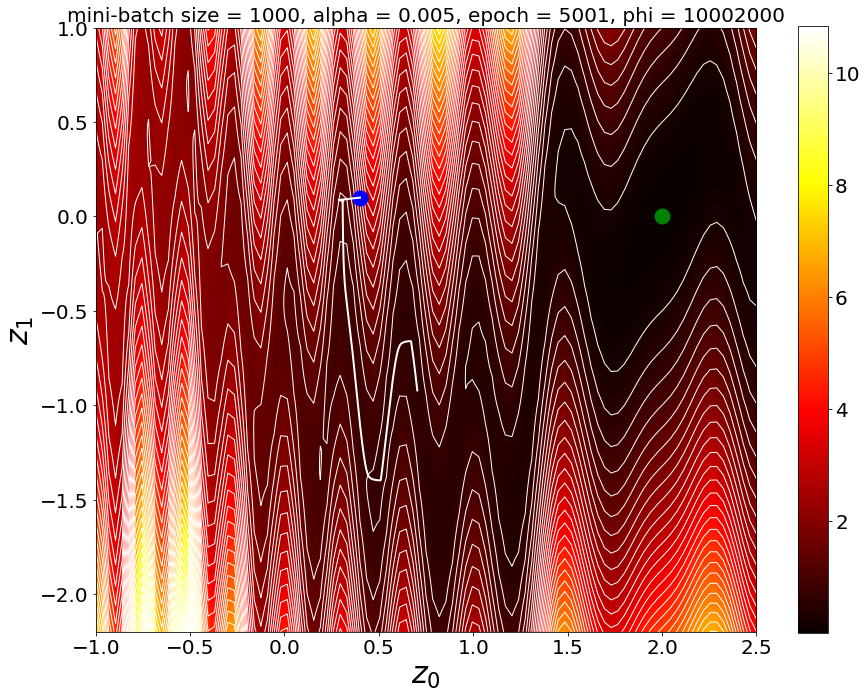

In [20]:
experiment(data.shape[0],0.005,plot_info)

max epochs exceeded.
number of steps: 5002
[[7.18419456 6.35968159 4.96102037 ... 4.80770107 4.28915975 4.00479152]
 [7.04670355 6.23451957 4.86044195 ... 4.67068126 4.16040471 3.8809698 ]
 [6.91126053 6.11140555 4.76191152 ... 4.53570944 4.03369768 3.75919607]
 ...
 [3.4442192  3.82794746 4.83847872 ... 1.1139035  1.40531045 1.60440646]
 [3.50743219 3.90348944 4.9386043  ... 1.17758769 1.47725941 1.68128874]
 [3.57269318 3.98107941 5.04077787 ... 1.24331987 1.55125638 1.76021901]]


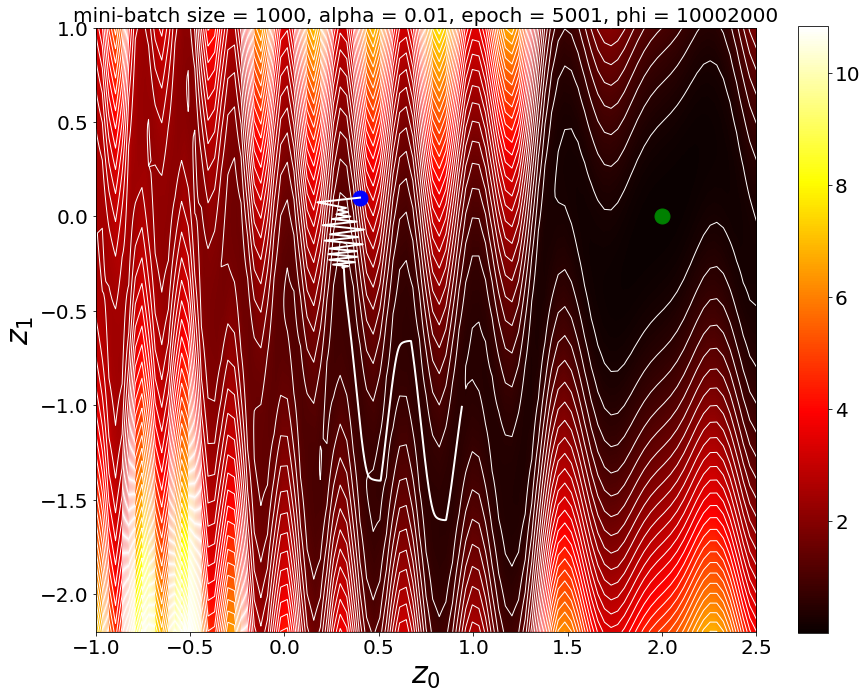

In [13]:
experiment(data.shape[0],0.01,plot_info)

number of steps: 379


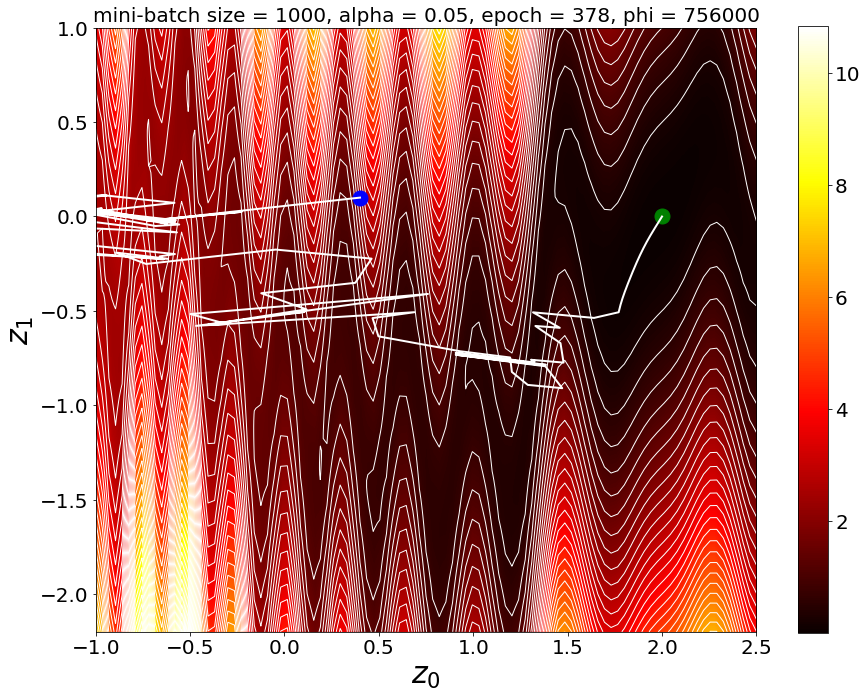

In [44]:
experiment(data.shape[0],0.05,plot_info)

### Problem 1.3 (Exam Style)

In problem 1.2, we conduct regular gradient descent on all the data samples with learning rates of 0.005, 0.01 and 0.05. For a learning rate of 0.005, the algorithm takes very little steps (albeit accurate, optimal) in the negative gradient direction and fails to converge with the given epoch limit. The experiment with a learning rate of 0.01 also fails to converge but travels further toward the global min than the algorithm with a learning rate of 0.005; however, due to the larger step size, you can see the algorithm oscillate a lot in the beginning, unable to find the optimal path downhill until a number of iterations. At a learning rate of 0.05, the algorithm takes wildy big steps and succeed in converging toward the global min within a rather small number of epochs (378); however, due to the large step size you can see the algorithm takes on big swings potentially attracted to local minimas off screen until finding its way back to the global min.

Because the dimensions and sample size for this problem is very tiny, we are able to make a whole 2D plot of the sample landscape and even visually spot the minima. However, this method cannot be feasibly generalized to larger problems with higher dimensionality and larger sample size. We are able to compare the different varying learning rates by applying them directly on the plot, but this would be very hard to do for larger problems because 1. there is no good way to visualize high dimensional graphs, 2. the algorithm would likely take a lot longer to converge/see any useful difference between the learning rates in a reasonable given epoch limit, 3. we don't know what the global min is (unlike how it's just given in this problem) in real life problems!

### Problem 1.4

max epochs exceeded.
number of steps: 50011


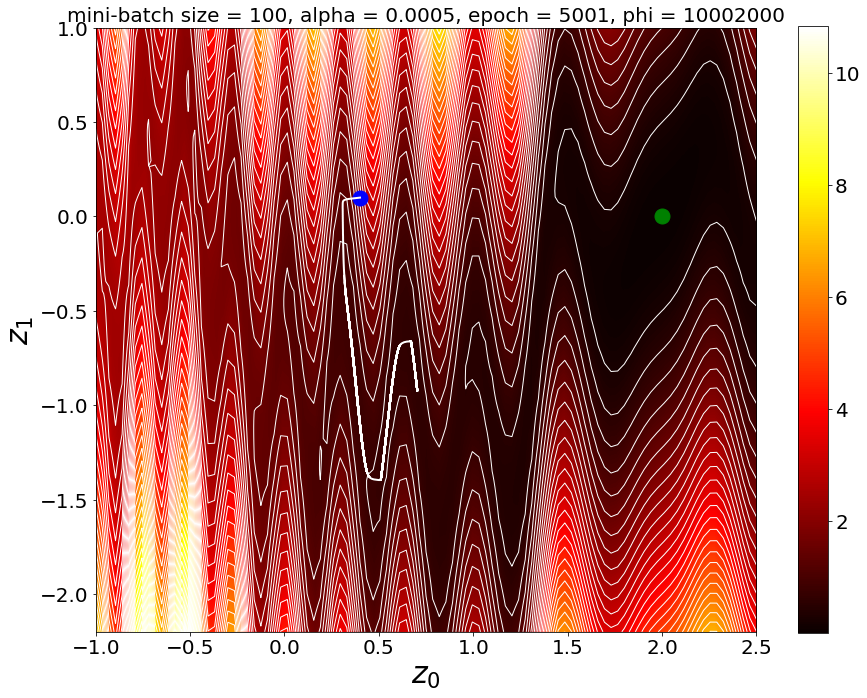

In [45]:
experiment(100,0.0005,plot_info)

max epochs exceeded.
number of steps: 50011


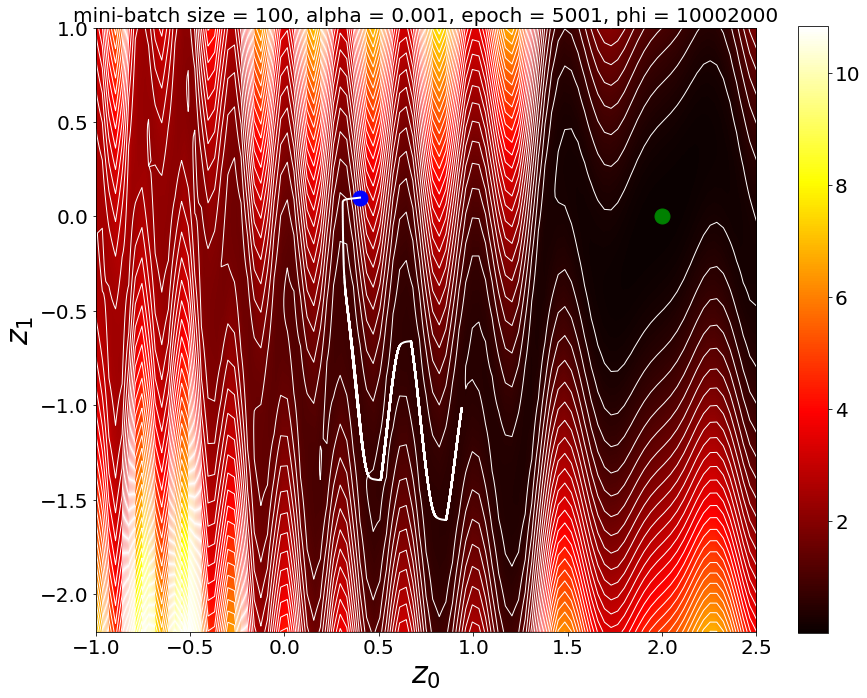

In [46]:
experiment(100,0.001,plot_info)

number of steps: 19241


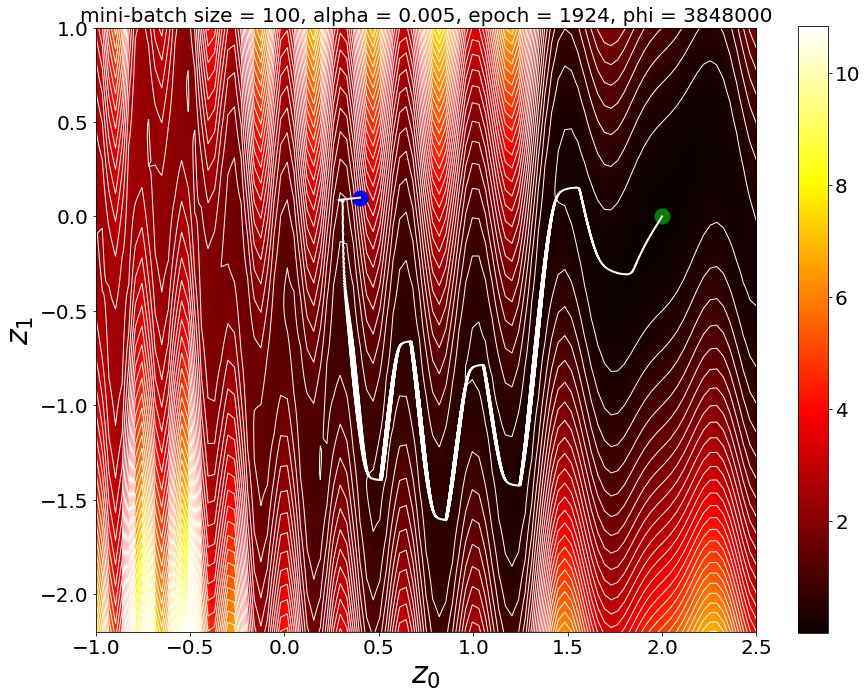

In [47]:
experiment(100,0.005,plot_info)

number of steps: 10891


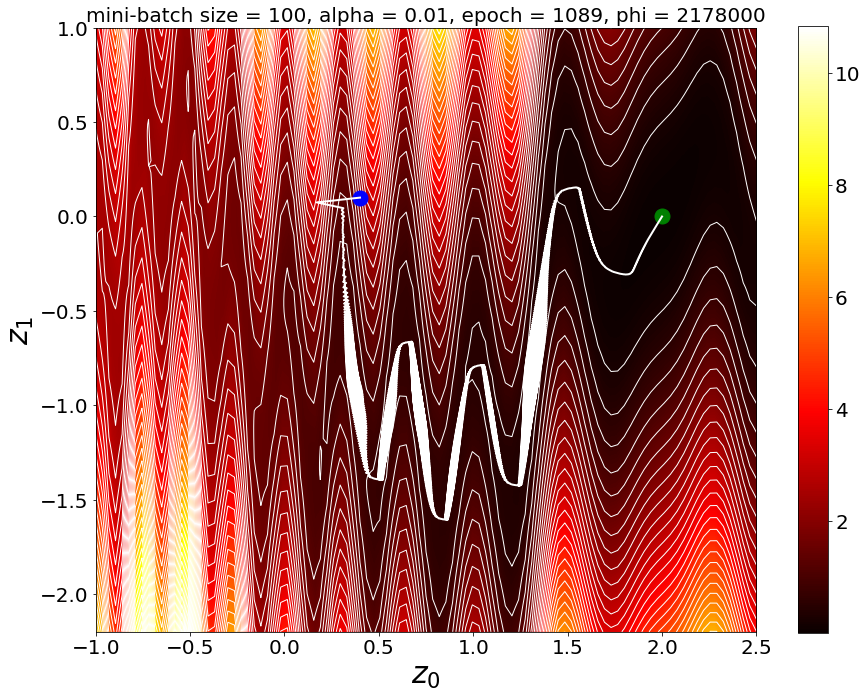

In [48]:
experiment(100,0.01,plot_info)

### Problem 1.5 (Exam Style)

In problem 1.4, we experiment with four different learning rates on a stochastic gradient descent based algorithm with a batch size of 100. 

With a learning rate of 0.0005, the algorithm fails to converge with its tiny steps; since the steps are super tiny, it suffers the least oscillations and noise originating from the use of batches. 

With a learning rate of 0.001, the algorithm is taking slightly larger steps but also fails to converge within the epoch limit; There is visibly slightly more oscillation/noise associated with the slightly higher learning rate compared to 0.0005; we can start to see, however, that stochastic gradient descent is already doing better than the ordinary gradient descent with the algorithm progressing faster even with a smaller learning rate. 

With a learning rate of 0.005, the stochastic algorithm succeeds in converging toward the global min with 1924 epochs, with 3848000 phi calls. There is visibly more noise/oscillation involved with a higher learning rate: the path looks to be zigzagging toward the global min.

With a learning rate of 0.01, the algorithm suceeds in converging toward the glbal min in 1089 epochs and 2178000 phi calls; we can see a great deal of noise/oscillation associated with the large learning rate for this algorithm, the price it pays for converging in the shortest amount of evaluations.

Concerning with the two cases for $\alpha = 0.005$ and $\alpha = 0.01$, I think a learning rate of $\alpha = 0.01$ is more preferable than $\alpha = 0.005$ given that the same batch size of 100 is used which means that the GPU storage is the same for both. Even though with a learning rate of 0.01 the algorithm struggles with a path that involves way more zigzagging while the descent with a learning rate of 0.005 sees less noise in its path, the exploratory behavior of $\alpha = 0.01$ pays off as we can see that it converges much faster in 1089 epochs or 2178000 phi calls compared with 1924 epochs and 3848000 phi calls. If we consider the number of steps the two algoirthms has taken, the algorithm with a learning rate of $0.01$ took 10891 steps while the one with a learning rate of $0.005$ took 19241 steps, which means it is more efficient when we looks at the steps cost too. I think this exploratory behavior is preferable in this situation where we see increased efficiency.

I think it would be very difficult to select a good learning rate with this algorithm when z lives in space with many dimensions: 
1. there is no good way to visualize high dimensional space with a d > 3: since this problem concerns very small sample size, we are able to plot the parameters z in relation to f(z) in a 2d plot, this is near impossible to do in real life with larger sample sizes (whats the point of gd and sgd if we can visually spot the min as the darkest region?), which means that our method of comparing the varying learning rates would be hard to generalize -- while we could come up with a numerical way to compare the varying learning rates with for example euclidean distance between where it stops and the global min, it would be hard to see where and how much the algorithm oscillates and lingers 
2. We were given four different learning rates to experiment with: 0.0005, 0.001, 0.005, and 0.01. We are lucky to see that a learning rate of 0.01 converges toward the global min within a reasonable number of iterations. However, with a slight increase to the optimal learning rate among the four (0.01), for example using $\alpha = 0.015$, (figure shown below) we can see that the algorithm fails to converge within the epoch limit and is stuck oscillating in the descending path. It's more difficult to experiment with a whole spectrum of learning rates on larger sample sizes in higher dimensions. 
3. we don't know what the global min is in real life! 
4. the batch size of 100 is also a given which we didnt have to test for, and in higher dimensions larger samples it would take longer to determine an optimal batch size.

max epochs exceeded.
number of steps: 50011


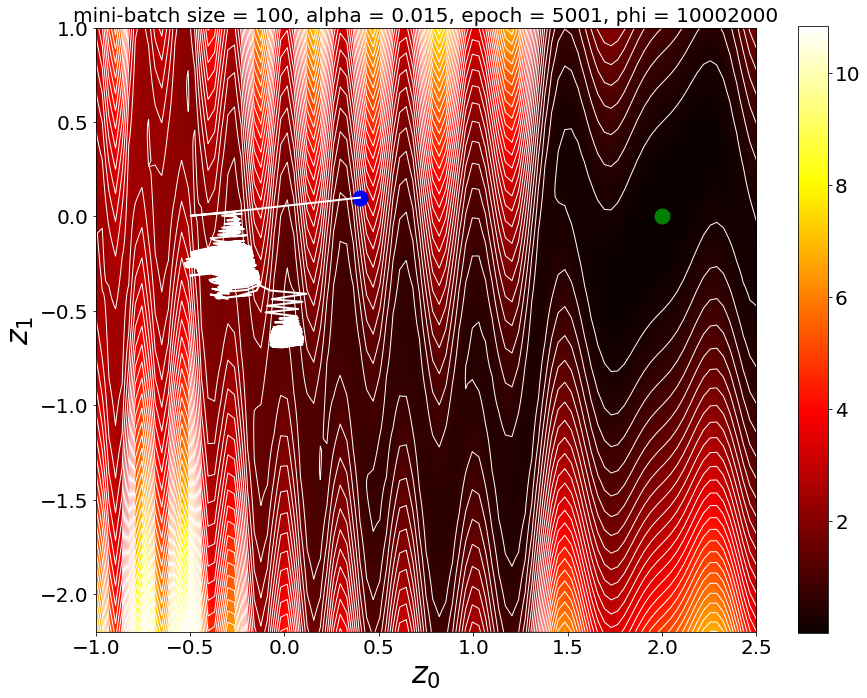

In [32]:
experiment(100,0.015,plot_info)

### Problem 1.6 (Exam Style)

One other reason why SGD may be preferable than the ordinary Gradient Descent could be that the algorithm converges much faster at the same learning rate. For example, if we compare the plot of SGD and plot of GD both with a learning rate of 0.005, SGD succeeds in finding the global min with 1924 epochs or 3848000 phi calls; GD on the other hand is barely one third of the way through the path toward the global min after 5001 epochs. This is because instead of evaluating over all samples for each step which takes significantly longer, SGD samples with $\phi$ and computes each step according to a sampled batch. While this also means that SGD takes way more steps than GD (about 10 times more when using a batch size of 100 instead of 1000 for the given sample size), it ends up being more efficient if we choose the right learning rate since we call $\phi$ a lot less times. 

More specifically, with SGD of batch size 100 for the given problem, we take 10 steps for each epoch compared to 1 step per epoch for ordinary GD (reasoning being that a factor of 10x decrease from batch size of 1000 results in an increase of a factor of 10x for the number of steps). Direction of the steps in SGD is determined based on a random batch sample of all data rather than the gradient over all data - this results in increased noise and oscillation that we can see in the SGD plots compared to the GD plots (some samples are better than others), but since the z value updates now is much more efficient (batch vs whole), we see results faster which means that the algorithm converges a lot faster. I think the step sizes are similar for both SGD and GD though, since the only difference between the two in terms of updating z involves how we are calculating the direction of descent (approx vs exact). Sizing depends more on $\alpha$.

## Part 2: Hyperplanes

### Problem 2.1 (Exam Style)

$$d = 1$$

### Problem 2.2 (Exam Style)

The point ${\bf p}$ is closer to the plane than to the origin.

### Problem 2.3 (Exam Style)

$$2x+2y+z = 6$$